In [15]:
# %%
from segment_anything import sam_model_registry, SamPredictor
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [16]:
# Paso 1: Cargar imagen
image_path = '../data/imgs/001.jpg'
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)



In [17]:
# Paso 2: Cargar modelo SAM
checkpoint_path = "../checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to(device=device)
predictor = SamPredictor(sam)

In [18]:
# Paso 3: Predecir la máscara del objeto principal
predictor.set_image(image_rgb)
height, width, _ = image_rgb.shape
input_point = np.array([[width // 2, height // 2]])
input_label = np.array([1])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True
)
best_mask = masks[np.argmax(scores)]

In [19]:
# Paso 4: Aplicar máscara para remover fondo
mask_uint8 = (best_mask * 255).astype(np.uint8)
image_nobg = cv2.bitwise_and(image_rgb, image_rgb, mask=mask_uint8)

In [20]:
# %%
# Paso 5: Mejorar contraste (CLAHE)
lab = cv2.cvtColor(image_nobg, cv2.COLOR_RGB2LAB)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
lab[:, :, 0] = clahe.apply(lab[:, :, 0])
image_clahe_rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# Paso 6: Convertir a HSV
hsv = cv2.cvtColor(image_clahe_rgb, cv2.COLOR_RGB2HSV)
hue = hsv[:, :, 0]
saturation = hsv[:, :, 1]
value = hsv[:, :, 2]

# Paso 7: Generar máscaras por color
mask_carne = (hue < 15) & (saturation > 60)
mask_grasa = (saturation < 50) & (value > 160)

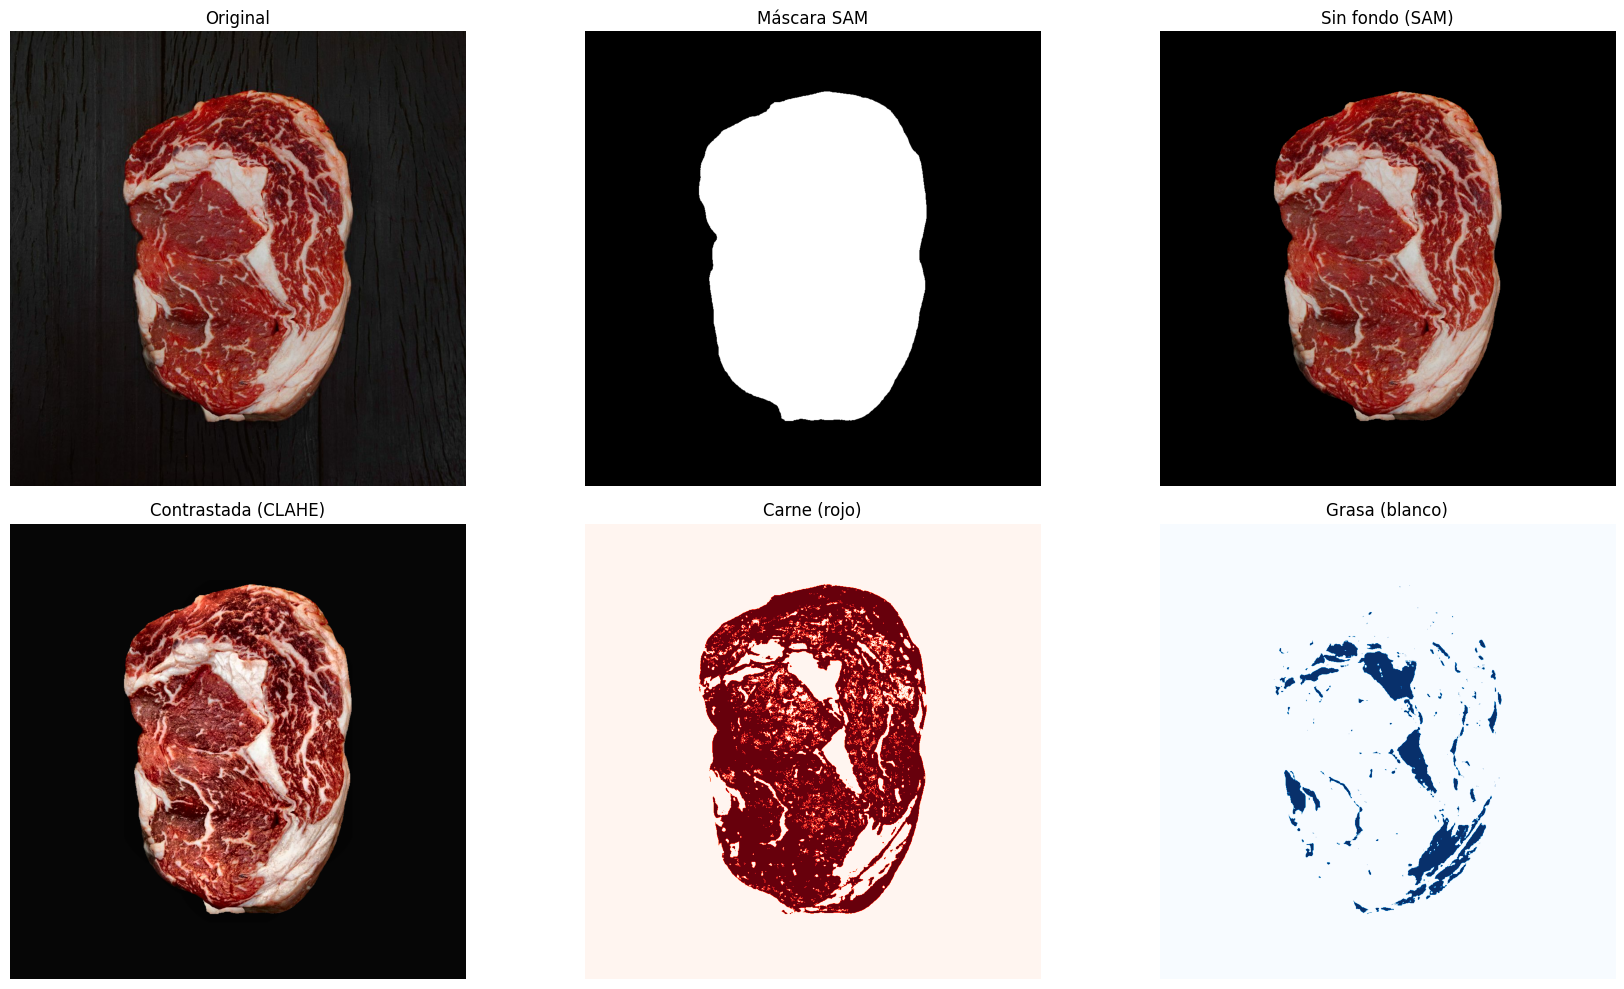

In [21]:
# %%
# Visualización final
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs[0, 0].imshow(image_rgb)
axs[0, 0].set_title("Original")
axs[0, 1].imshow(best_mask, cmap="gray")
axs[0, 1].set_title("Máscara SAM")
axs[0, 2].imshow(image_nobg)
axs[0, 2].set_title("Sin fondo (SAM)")
axs[1, 0].imshow(image_clahe_rgb)
axs[1, 0].set_title("Contrastada (CLAHE)")
axs[1, 1].imshow(mask_carne, cmap='Reds')
axs[1, 1].set_title("Carne (rojo)")
axs[1, 2].imshow(mask_grasa, cmap='Blues')
axs[1, 2].set_title("Grasa (blanco)")
for ax in axs.flat:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [22]:
# %%
# Guardar máscaras en formato PNG
carne_png = (mask_carne * 255).astype(np.uint8)
grasa_png = (mask_grasa * 255).astype(np.uint8)
cv2.imwrite('../data/masks/mask_carne.png', carne_png)
cv2.imwrite('../data/masks/mask_grasa.png', grasa_png)

# Guardar máscaras en formato NPY
np.save('../data/masks/mask_carne.npy', mask_carne)
np.save('../data/masks/mask_grasa.npy', mask_grasa)

print("Máscaras guardadas como PNG y NPY en la carpeta '../data/masks/'")


Máscaras guardadas como PNG y NPY en la carpeta '../data/masks/'


In [23]:
# Calcular el área válida (donde hay carne o grasa)
area_valida = np.sum(mask_carne | mask_grasa)

# Porcentaje proporcional
carne_pct = np.sum(mask_carne) / area_valida
grasa_pct = np.sum(mask_grasa) / area_valida

print(f"Carne: {carne_pct:.2%}")
print(f"Grasa: {grasa_pct:.2%}")


Carne: 85.17%
Grasa: 14.83%


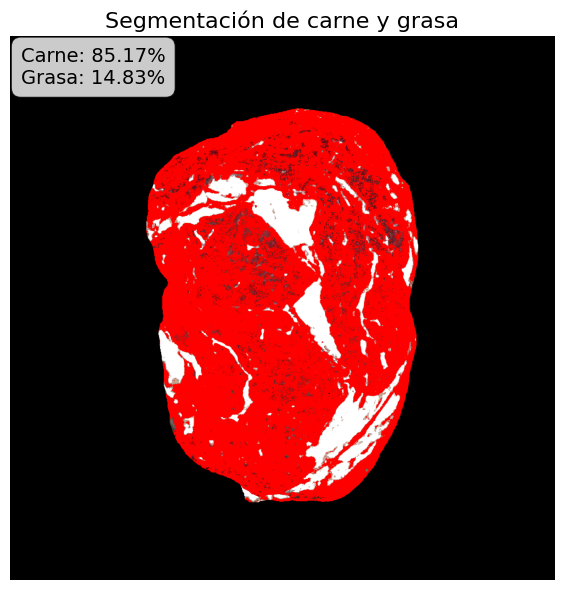

In [24]:
# %%
# Generar overlay
overlay = image_nobg.copy()
overlay[mask_carne] = [255, 0, 0]       # Rojo para carne
overlay[mask_grasa] = [255, 255, 255]   # Blanco para grasa

# Calcular proporciones relativas a la zona útil
area_valida = np.sum(mask_carne | mask_grasa)
carne_pct = np.sum(mask_carne) / area_valida
grasa_pct = np.sum(mask_grasa) / area_valida

# Crear figura resumen
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(overlay)
ax.set_title("Segmentación de carne y grasa", fontsize=16)
ax.axis("off")

# Agregar texto con porcentajes
text = f"Carne: {carne_pct:.2%}\nGrasa: {grasa_pct:.2%}"
props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
ax.text(0.02, 0.98, text, transform=ax.transAxes,
        fontsize=14, verticalalignment='top', bbox=props, color='black')

# Mostrar y guardar
plt.tight_layout()
# plt.savefig("../data/reports/segmentacion_resumen.png", dpi=300)
plt.show()
